## Diffraction Simulation using diffractsim

By      : Irfan Imaduddin <br>
Date    : 11 June 2022 <br>
Ref     : github.com/rafael-fuente/diffractsim <br>
Version : 2.2.1 <br>
Contact : irfanimaduddin@gmail.com <br>

---

# Install package

In [1]:
!pip install diffractsim

# Import necessary packages and set backend.

Note:
* CPU = CPU
* CUDA = GPU (recommended!)

In [2]:
import diffractsim
import numpy as np

diffractsim.set_backend("CUDA") #Change the string to "CUDA" to use GPU acceleration

In [3]:
from diffractsim import MonochromaticField, ApertureFromImage, CircularAperture, Lens, W, m, cm, mm, um, nm, bd

from diffractsim.colour_functions import ColourSystem as cs
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

plt.style.use("dark_background")

# Optical layout 

<img src="https://raw.githubusercontent.com/irfanimaduddin/doublestar_grating_diffraction/main/layout.png" height="500px"/>

Define some variables

In [4]:
WAVELENGTH=555*nm

F_VIS = 1078*cm
F_PHO = 1072*cm

D_TEL = 600*mm
R_TEL = D_TEL/2.

D_GRAT = 738*mm
R_GRAT = D_GRAT/2.

D_PUPIL = 800*mm
R_PUPIL = D_PUPIL/2.

DIST_GRAT_LENS = 20*cm
DIST_PUPIL_GRAT = 30*cm

PLOT_LIM_PUPIL = 425*mm
PLOT_LIM_GRAT = 325*mm
PLOT_LIM_LENS = 325*mm

Define the information to some variables

# Initialize light source

Concept

<img src="https://raw.githubusercontent.com/irfanimaduddin/doublestar_grating_diffraction/main/Extent_NX_NY.png" width="250px"/>

The light source is assumed as paraxial rays. 

Monochromatic light source

In [5]:
F = MonochromaticField(
    wavelength=WAVELENGTH, # Wavelength for monochromatic light source in nm
    extent_x=200*cm, # Width of the light source assumed as rectangular (set larger than your aperture)
    extent_y=200*cm, # Height of the light source assumed as rectangular (set larger than your aperture)
    Nx=2048, # Number of pixels or grids for an extent_x value in x axis
    Ny=2048, # Number of pixels or grids for an extent_y value in y axis
    intensity=1e-7*W/(m**2) # Intensity of the light source in W/m2 (default: 0.2)
)

# Some information about fluxes arrived above the Earth atmosphere
# Sun flux = 1380 W/m2
# Sirius flux = 10-7 W/m2

# Add circular aperture right after the light source

It's assumed as entrance pupil of the telescope

In [6]:
F.add(CircularAperture(radius=R_PUPIL))

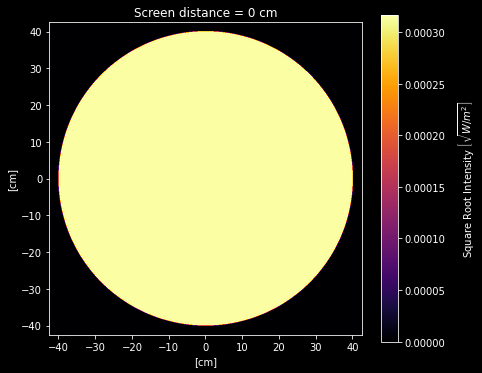

In [7]:
I = F.get_intensity()
F.plot_intensity(I,square_root=True, units=cm, xlim=(-PLOT_LIM_PUPIL, PLOT_LIM_PUPIL), ylim=(-PLOT_LIM_PUPIL, PLOT_LIM_PUPIL))

# Add grating (optional)

Propagate light as long as $d_{pupil-grating}$.

In [8]:
F.propagate(DIST_PUPIL_GRAT)

/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:454: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


Add grating

In [9]:
F.add(ApertureFromImage("./apertures/violin_aper_4_grating_round.png", image_size=(D_GRAT, D_GRAT), simulation=F))

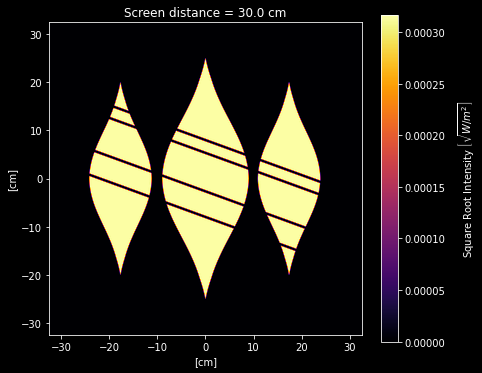

In [10]:
I = F.get_intensity()
F.plot_intensity(I,square_root=True, units=cm, xlim=(-PLOT_LIM_GRAT, PLOT_LIM_GRAT), ylim=(-PLOT_LIM_GRAT, PLOT_LIM_GRAT))

# Add Thick Lens (could be more than one).

Propagate light as long as $d_{grating-lens}$.

In [11]:
F.propagate(DIST_GRAT_LENS+DIST_PUPIL_GRAT)

Add lens where the focal length values are:
* $F_{visual} = 1078$ cm
* $F_{photography} = 1072$ cm

In [12]:
def propagate_to_lens_focal_plane(F, focal_length, x_interval, y_interval):
    """
    
    Add a lens with focal_length and compute the field in distance equal to focal_length with the Bluestein method. 
    The output plane can be arbitrarily chosen by using the arguments x_interval and y_interval

    Parameters
    ----------
    F: Simulation object
    focal_length: focal_length of the lens
    x_interval: A length-2 sequence [x1, x2] giving the x outplut plane range
    y_interval: A length-2 sequence [y1, y2] giving the y outplut plane range

    
    BSD 3-Clause License
    Copyright (c) 2022, Rafael de la Fuente
    All rights reserved.
    
    """

    global bd
    from diffractsim.util.backend_functions import backend as bd
    from diffractsim.util.bluestein_FFT import bluestein_fft2, bluestein_fftfreq

    
    C = bluestein_fft2(F.E, x_interval[0] / (focal_length*F.λ), x_interval[1] / (focal_length*F.λ), 1/F.dx, 
                        y_interval[0] / (focal_length*F.λ), y_interval[1] / (focal_length*F.λ), 1/F.dy)
    dfx = 1/(F.Nx*F.dx)
    dfy = 1/(F.Ny*F.dy)
    fx_zfft = bluestein_fftfreq(x_interval[0]/ (focal_length*F.λ),x_interval[1]/ (focal_length*F.λ), F.Nx)
    fy_zfft = bluestein_fftfreq(y_interval[0]/ (focal_length*F.λ),y_interval[1]/ (focal_length*F.λ), F.Ny)
    dfx_zfft = fx_zfft[1]-fx_zfft[0]
    dfy_zfft = fy_zfft[1]-fy_zfft[0]
    nn, mm = bd.meshgrid((bd.linspace(0,(F.Nx-1),F.Nx)*dfx_zfft/dfx ), (bd.linspace(0,(F.Ny-1),F.Ny)*dfy_zfft/dfy ))
    ft_factor = (F.dx*F.dy* bd.exp(bd.pi*1j * (nn + mm)))
    F.x = fx_zfft*(focal_length*F.λ)
    F.y = fy_zfft*(focal_length*F.λ)
    F.xx, F.yy = bd.meshgrid(F.x, F.y)
    F.dx = F.x[1] - F.x[0]
    F.dy = F.y[1] - F.y[0]
    F.extent_x = F.x[1] - F.x[0] + F.dx
    F.extent_y = F.y[1] - F.y[0] + F.dy

    F.E = C*ft_factor * bd.exp(1j*bd.pi/(F.λ*focal_length)  * (F.xx**2 + F.yy**2)  +   1j*2*bd.pi/F.λ * focal_length ) / (1j*focal_length*F.λ)
    F.z += focal_length
    
propagate_to_lens_focal_plane(F, F_VIS, x_interval = [-150*um, 150*um], y_interval = [-150*um, 150*um])

# Intensity Plot of The System

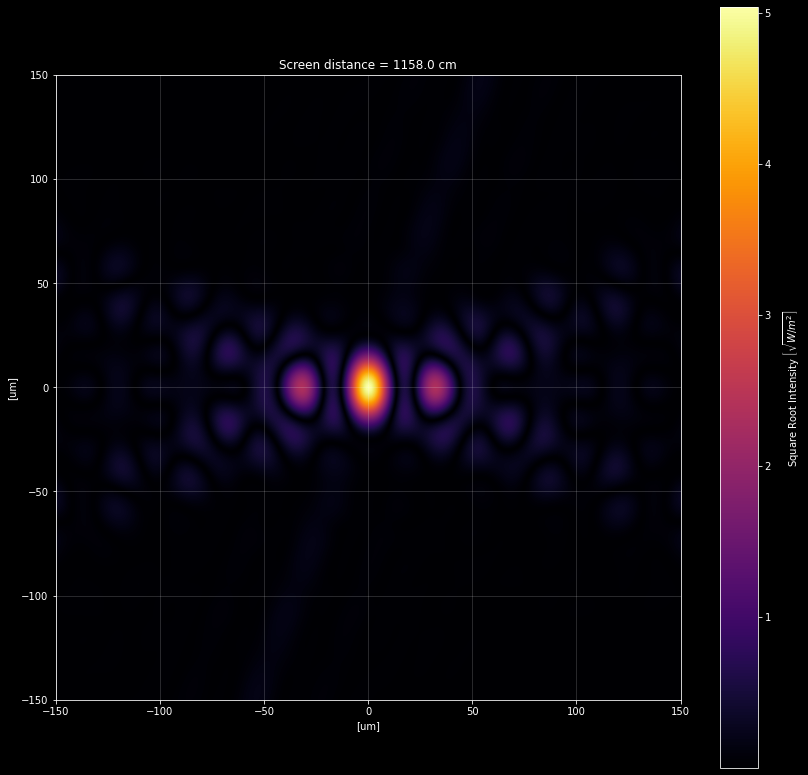

In [13]:
#Plot the PSF of the telescope
I = F.get_intensity()
F.plot_intensity(I, grid = True, figsize = (14,14), square_root=True, units =um, xlim = [-150 * um, 150 * um], ylim = [-150*um, 150*um])

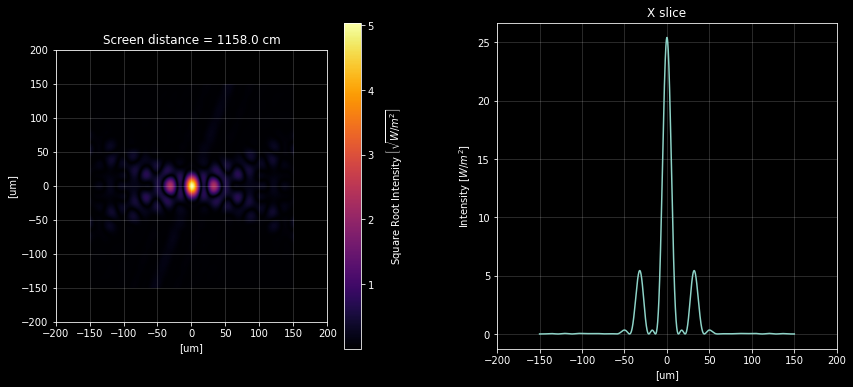

In [14]:
#Plot the PSF of the telescope

I = F.get_intensity()
F.plot_intensity(I, grid = True,figsize = (14,6), square_root=True, units =um, slice_y_pos = 0*mm, xlim = [-200 * um, 200 * um], ylim = [-200 * um, 200 * um])

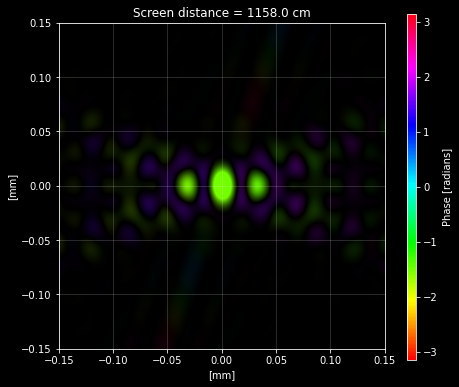

In [15]:
# plot the phase of the PSF and check there is no aliasing to continue with new propagations
E = F.get_field()
F.plot_phase(E, grid = True)

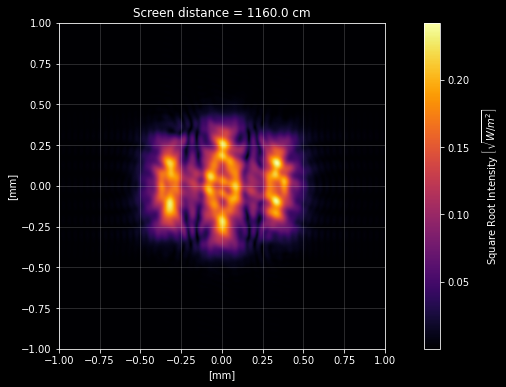

In [16]:
#propagate 2*cm from the focal point


F.zoom_propagate(2*cm, x_interval = [-1*mm, 1*mm], y_interval = [-1*mm, 1*mm])
I = F.get_intensity()
F.plot_intensity(I, grid = True,figsize = (14,6), square_root=True, units =mm)

In [17]:

import copy
F2 = copy.deepcopy(F)



# Playing with Focal length

Imagine that we are setting the focal length experimentally to get the best focus. We already know that we are looking for the smallest diameter of the object at this process. But actually, we're looking for the best RMS in radius $R$ axis ($R^2=x^2+y^2$).

In [18]:
# Initialize the light source as well

F = MonochromaticField(
    wavelength=555 * nm, # Wavelength for monochromatic light source in nm
    extent_x=100*cm, # Width of the light source assumed as rectangular (set larger than your aperture)
    extent_y=100*cm, # Height of the light source assumed as rectangular (set larger than your aperture)
    Nx=2048, # Number of pixels or grids for an extent_x value in x axis
    Ny=2048, # Number of pixels or grids for an extent_y value in y axis
    intensity=1e-7*W/(m**2) # Still using Sirius flux in W/m2 (default: 0.2)
)

# Add the circular aperture
F.add(CircularAperture(radius=R_PUPIL))

# Set grating distance from the aperture
F.propagate(DIST_PUPIL_GRAT)

# Add grating
F.add(ApertureFromImage("apertures/violin_aper_4_grating_round.png", image_size=(D_GRAT, D_GRAT), simulation=F))

# Set lens distance from the grating
F.propagate(DIST_GRAT_LENS)

propagate_to_lens_focal_plane(F, F_VIS, x_interval = [-1000*um, 1000*um], y_interval = [-1000*um, 1000*um])




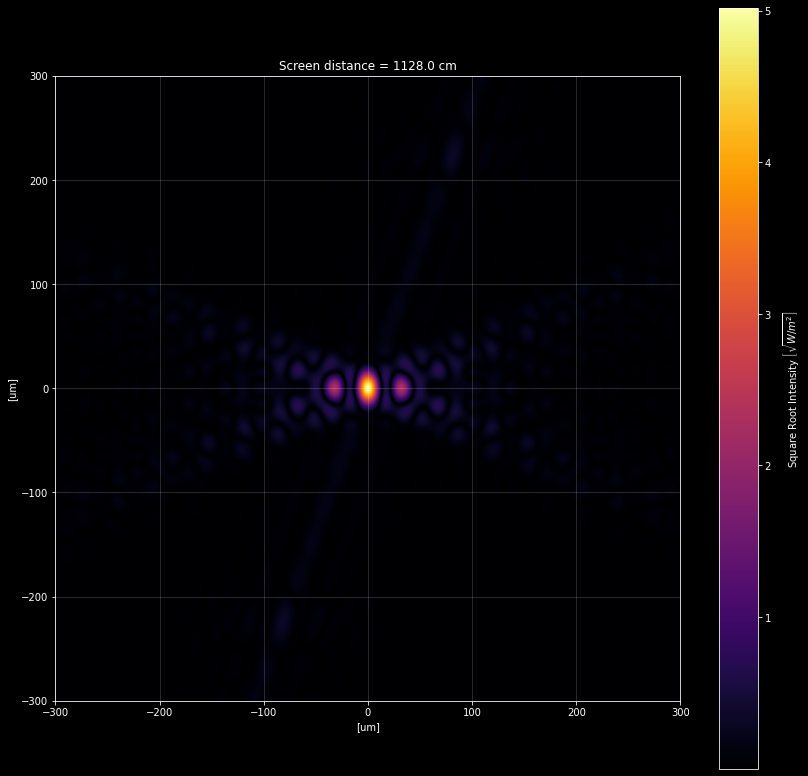

In [19]:
#Plot the PSF of the telescope
I = F.get_intensity()
F.plot_intensity(I, grid = True, figsize = (14,14), square_root=True, units =um, xlim = [-300 * um, 300 * um], ylim = [-300*um, 300*um])

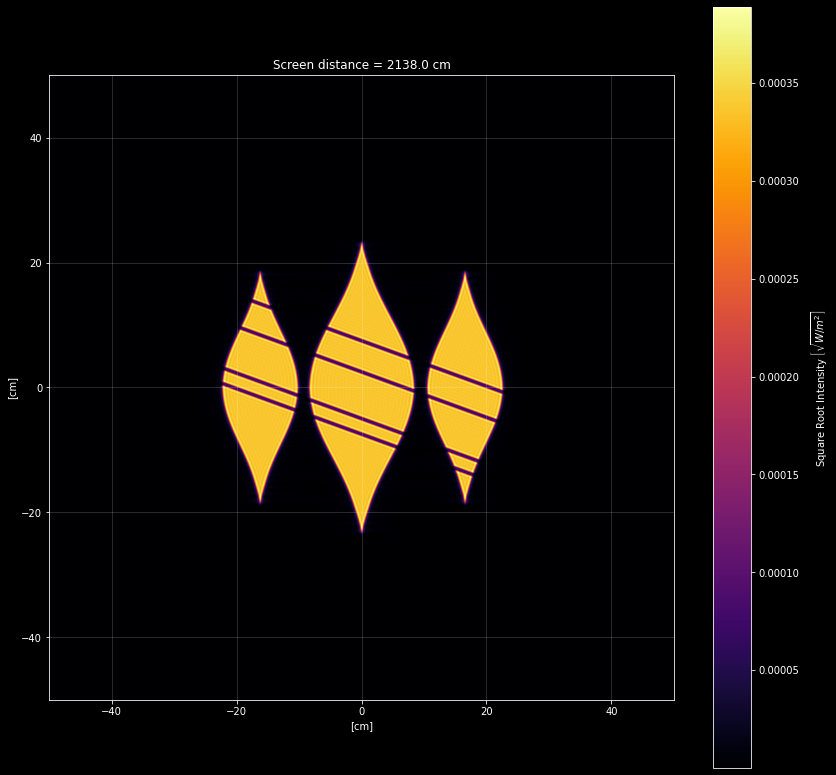

In [20]:
#propagate 1010*cm from the focal point

hi = 1010*cm


F.zoom_propagate(hi, x_interval = [-50*cm, 50*cm], y_interval = [-50*cm, 50*cm])
I = F.get_intensity()
F.plot_intensity(I, grid = True, figsize = (14,14), square_root=True, units =cm)

